<h1> Байесовский классификатор </h1>
В машинном обучении — семейство простых вероятностных классификаторов, основанных на использовании теоремы Байеса и «наивном» предположении о независимости признаков классифицируемых объектов.
По сути, байесовский классификатор представляет собой вероятностную модель. Пусть задано множество наблюдений, каждое из которых представлено вектором признаков 
$x=(x_1,x_2,...,x_n)$. Модель присваивает каждому наблюдению условную вероятность $p(y_{k}|x_1,x_2,...,x_n)$, k — класс. <br>
<h2>$p(y_{k}|x) = \frac{p(y_{k})p(x|y_{k})}{p(x)}$ </h2> <br>
$p(y) $ - априорная вероятность класса yk <br>
$p(x|y_{k}) $ - функция правдоподобия класса yk <br>
$p(y_{k}|x) $ - апостериорная вероятность класса yk <br>

В этой формуле интерес с точки зрения классификации представляет только числитель, поскольку знаменатель от метки классов не зависит и является константой. 
При условии, что признаки независимы, можно показать, что
$p(y_k|x_1,x_2,...,x_n)=p(y_k)p(x_1|y_k)p(x_2|y_k)...p(x_n|y_k)=\prod_n p(x_i|y_k)$ <br>
Тогда простой байесовский классификатор можно рассматривать как функцию, которая каждому выходному значению 
модели присваивает метку класса, т.е. 
$a(x) = y_k следующим образом:$ <br>
<h2>$a(x) = arg_k max_{1...k} \prod_n p(x_i|y_k)$ </h2> <br>

Таким образом, выбирается класс $y_k$, который максимизирует функцию правдоподобия, представляющую собой произведение 
условных вероятностей значений признака $x_i$ по каждому классу $y_k$. <br>
Вероятностный классификатор предсказывает класс с самой большой условной вероятностью для заданного вектора признаков x.






<center> <img src="img/NB2.png", width="600">

__Востановления плотности по импирическим данным__

Истинное распределение р(х|у) не известно, востановим данную плотность $\hat{р}(х|у,Х) $

In [13]:
#!git clone https://github.com/andriygav/MixtureLib.git
#!python3 -m pip install MixtureLib/src/.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
from mixturelib.local_models import EachModelLinear
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet
from mixturelib.mixture import MixtureEM

import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from scipy import stats
import numpy as np
from sklearn import tree, base
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression, load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
import torch

In [ ]:
#Сгенерируем распределение
np.random.seed(42)
l=10000
p_x_1 = stats.norm(-1,0.5)
x_1 = np.sqrt(0.5)*np.random.randn(l)-1
p_x_2 = stats.norm(1, 1.5)
x_2 = np.sqrt(1.5)*np.random.randn(l)+1

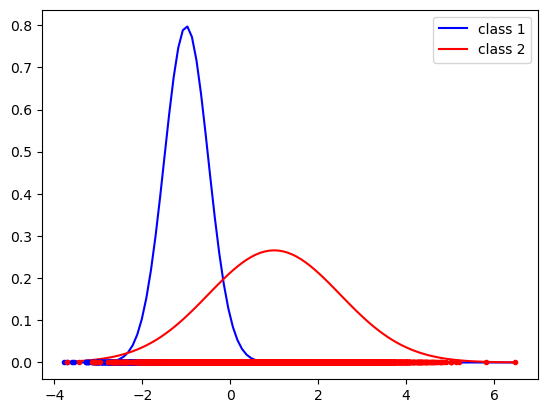

In [5]:
#Построим графики x - объект у- плотность вероятности
x = np.linspace(min(np.min(x_1), np.min(x_2)),
            max(np.max(x_1), np.max(x_2)), 100)
plt.plot(x, p_x_1.pdf(x), color='blue', label='class 1')
plt.plot(x, p_x_2.pdf(x), color='red', label='class 2')
plt.plot(x_1, x_1*0,'.', color='blue')
plt.plot(x_2, x_2*0,'.',color='red')
plt.legend(loc='best')
plt.show()


In [ ]:
# Определяем величину плотности вероятности на интервале около точки x  используется метрика Минковского  metric='minkowski'
def p(x, D, h = 0.2):
    D = np.array(D)
    x = np.array(x)
    l = len(D)
    n = 1
    if len(D.shape) == 2:
        n = D.shape[1]
    D = D.reshape([-1, n])
    x = x.reshape([-1, n])
    return (1/(2*h))*(1/len(D))*(cdist(D, x, metric='minkowski', p=1) <= h).sum(axis=0)

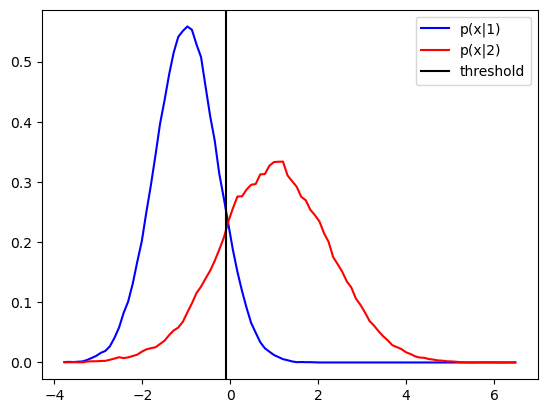

In [ ]:
# Строим востанавливающую модель
x = np.linspace(min(np.min(x_1), np.min(x_2)),
            max(np.max(x_1), np.max(x_2)), 100)
plt.plot(x, p(x, x_1), color ='blue', label = 'p(x|1)')
plt.plot(x, p(x, x_2), color = 'red', label ='p(x|2)')

plt.axvline(-0.1, color = 'black', label = 'threshold')

plt.legend(loc='best')
plt.show()

__Смесь распределений__

In [ ]:
color = ['blue', 'red']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
np.random.seed(42)
N = 200
noise_component = 0.8
noise_target = 5

X = np.random.randn(N, 2)
X[:N//2, 1] *= noise_component
X[:N//2] += np.array([-2,-2])
X[N//2:, 0] *= noise_component
X[N//2:] +- np.array([2,2])

real_first_w = np.array([[10.], [0.]])
real_second_w = np.array([[0.], [30.]])
y = np.vstack([X[:N//2]@real_first_w, X[N//2:]@real_second_w]) + noise_target*np.random.randn(N, 1)

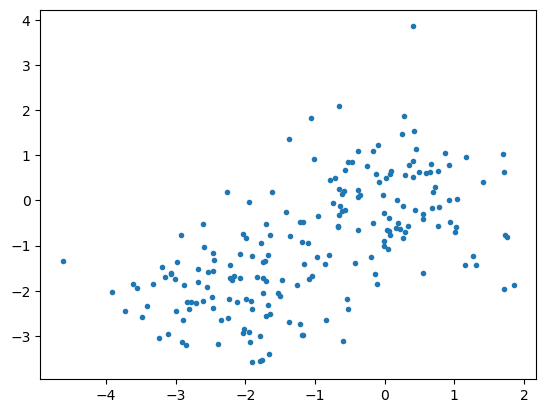

In [10]:
plt.plot(X[:, 0], X[ :, 1], '.')
plt.show()

In [ ]:
torch.random.manual_seed(42)
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(y)

In [12]:
#Первая и вторам модели
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=2)
secode_model = EachModelLinear(input_dim=2)
list_of_models = [first_model, secode_model]

In [15]:
# Гипермодель
HpMd = HyperExpertNN(input_dim=2, hidden_dim=5, output_dim=2, epochs=100)

In [ ]:
# Создание смеси
mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels= list_of_models,
                    model_type='sample')

In [20]:
# Обучение
List_of_ind=[]
List_of_W=[]
for _ in tqdm(range(10)):
    mixture.fit(X_tr, Y_tr, 1)
    List_of_ind.append(np.argmax(mixture.predict(X_tr)[1], axis = 1))
    List_of_W.append(np.array([m.W.data.numpy().reshape(-1) for m in mixture.ListOfModels]))

List_of_ind = np.array(List_of_ind)
List_of_W = np.array(List_of_W)


  0%|          | 0/10 [00:00<?, ?it/s]

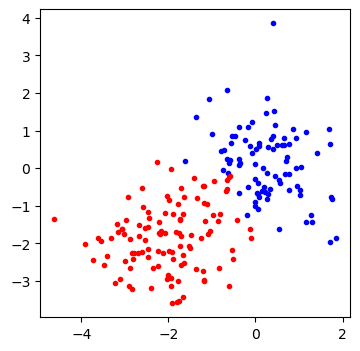

In [ ]:
# Отображение
fig = plt.figure(figsize=(4.0, 4.0))
pred_type = np.argmax(mixture.predict(X_tr)[1], axis=-1)
for i in np. unique (pred_type):
    plt.plot(X[pred_type==i, 0], X[pred_type==i, 1], '.', color=color[i], label= 'type {}'.format(i))

plt.show()

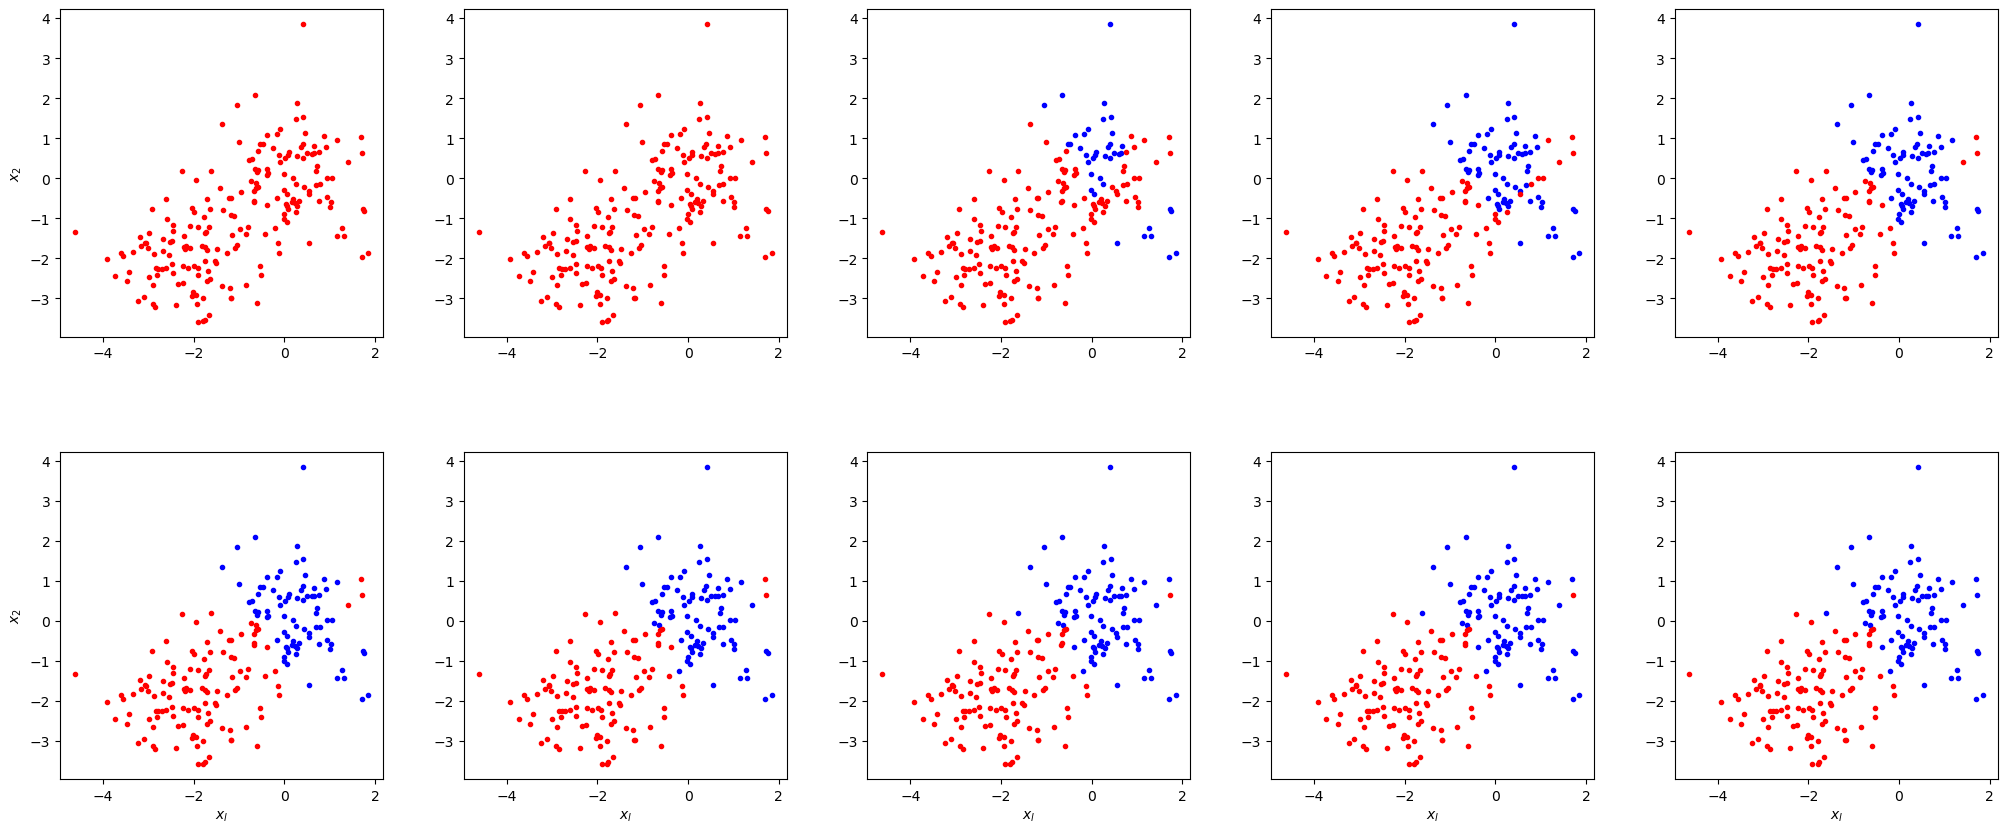

In [ ]:
fig = plt.figure(figsize=(25.0, 10.0))
gs = gridspec.GridSpec(2, 5)
ax = []

for i, g in enumerate(gs):
    ax.append(fig.add_subplot(g))
    if (len(ax) - 1) % 5 == 0:
        ax[-1].set_ylabel('$x_2$')
    if len(ax) > 5:
        ax[-1].set_xlabel('$x_l$')

for e, (idx, _) in enumerate(zip(List_of_ind[:10], List_of_W[:10])):
    for i in np.unique(idx):
        indexes = np.where(idx == i)
        _ = ax[e].plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.show()


In [ ]:
Задание:
1. Изучить материал по ссылке:https://mixturelib.readthedocs.io/en/latest/info.html
2. Используя датасет по ирисам Фишера, с помощью байесовского классификатра
    a) проивзести востановление плотности по данным;
    b) разделить ирисы на классы;
    с) Представить результат графически и найти точность.



Точность: 0.6889

              precision    recall  f1-score   support

      setosa       0.94      1.00      0.97        15
  versicolor       0.56      0.60      0.58        15
   virginica       0.54      0.47      0.50        15

    accuracy                           0.69        45
   macro avg       0.68      0.69      0.68        45
weighted avg       0.68      0.69      0.68        45

Матрица ошибок:
[[15  0  0]
 [ 0  9  6]
 [ 1  7  7]]


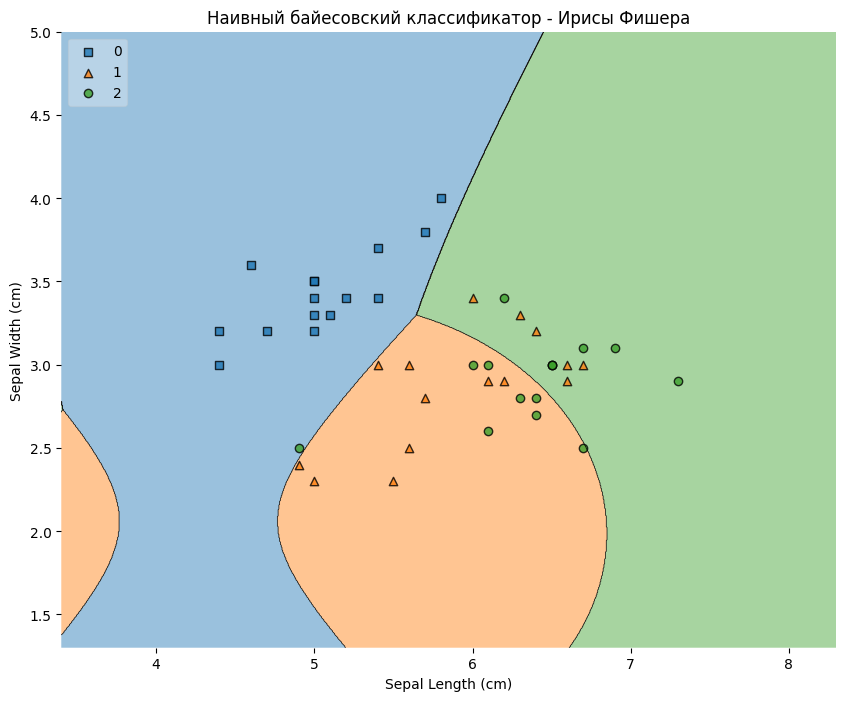

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_decision_regions
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

iris = load_iris()
X = iris.data[:, :2]
y = iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность: {accuracy:.4f}\n")

print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)

plt.figure(figsize=(10, 8))
plot_decision_regions(X_test, y_test, clf=gnb, legend=2)
plt.title("Наивный байесовский классификатор - Ирисы Фишера")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.show()